<a href="https://colab.research.google.com/github/AbiralShakya/dhunga/blob/main/ModelRev1/mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abiralshakya","key":"10fe993046fdd92372971dc9285f5157"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d "ishworsubedii/nepali-speech-to-text-dataset"

Dataset URL: https://www.kaggle.com/datasets/ishworsubedii/nepali-speech-to-text-dataset
License(s): unknown
100% 1.00G/1.01G [00:33<00:00, 33.8MB/s]
100% 1.01G/1.01G [00:33<00:00, 32.0MB/s]


In [ ]:
!unzip nepali-speech-to-text-dataset.zip


Archive:  nepali-speech-to-text-dataset.zip
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_1.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_10.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_11.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_12.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_13.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_14.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_15.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_16.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_17.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_18.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_19.wav  
  inflating: Nepali Speech To Text Dataset/audio_chunks/2079-11-21_2.wav  
  inflating: Nepali Speech To Text Dataset/aud

In [ ]:
import librosa
import os
import numpy as np

wav_file_path = "/content/Nepali Speech To Text Dataset/audio_chunks"

all_audio_data = []

for filename in os.listdir(wav_file_path):
    if filename.endswith(".wav"):
        file_path = os.path.join(wav_file_path, filename)
        audio, sr = librosa.load(file_path)
        all_audio_data.append(audio)

combined_audio = np.concatenate(all_audio_data)

print(combined_audio.shape)
print(sr)

(217644308,)
22050


In [ ]:
import librosa
import numpy as np

def standardize_audio(file_path, target_sr=44100, target_duration=6):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)  # Use native sampling rate
    audio = librosa.resample(audio, orig_sr = sr, target_sr = target_sr)  # Resample to 44100 Hz

    # Convert to stereo by duplicating mono channel
    if len(audio.shape) == 1:  # Mono audio
        audio = np.vstack([audio, audio]).T  # Convert to stereo (2 channels)

    # Trim or pad the audio to the target duration
    target_samples = target_sr * target_duration
    if audio.shape[0] > target_samples:  # Trim if longer
        audio = audio[:target_samples]
    else:  # Pad with silence if shorter
        padding = target_samples - audio.shape[0]
        audio = np.pad(audio, ((0, padding), (0, 0)), mode='constant')

    return audio, target_sr

#audio_path = '/content/your_wav_files/sample.wav'
#standardized_audio, standardized_sr = standardize_audio(audio_path)

In [ ]:
def add_gaussian_noise(audio, mean=0, std=10):
    noise = np.random.normal(mean, std, audio.shape)
    noisy_audio = audio + noise
    return np.clip(noisy_audio, -1, 1)  # Clip values to [-1, 1] for audio safety

#noisy_audio = add_gaussian_noise(standardized_audio)

In [ ]:
def preprocess_audio_for_mfcc(audio, sr, alpha=0.97, n_mfcc=64, n_fft=2048, hop_length=512):
    # Apply pre-emphasis
    emphasized_audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=emphasized_audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # Apply windowing (you can use a hamming window for this)
    windowed_mfcc = librosa.util.normalize(mfcc, axis=-1)

    return windowed_mfcc

#mfcc_features = preprocess_audio_for_mfcc(noisy_audio, standardized_sr)

In [18]:
import os
import librosa
import numpy as np
import subprocess

def process_audio_file(file_path, target_sr=44100, target_duration=6, alpha=0.97):
    # Standardize
    standardized_audio, sr = standardize_audio(file_path, target_sr, target_duration)

    # Add Gaussian noise
    noisy_audio = add_gaussian_noise(standardized_audio)

    # Preprocess for MFCC
    mfcc_features = preprocess_audio_for_mfcc(noisy_audio, sr, alpha)

    return mfcc_features

# Folder with audio files
input_folder = "/content/Nepali Speech To Text Dataset/audio_chunks"
output_mfcc_folder = '/content/processed_mfcc_files'
os.makedirs(output_mfcc_folder, exist_ok=True)

# Process all audio files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith('.wav'):
        file_path = os.path.join(input_folder, filename)
        mfcc = process_audio_file(file_path)

        # Save the MFCC to file
        mfcc_file_path = os.path.join(output_mfcc_folder, f"{os.path.splitext(filename)[0]}.npy")
        np.save(mfcc_file_path, mfcc)


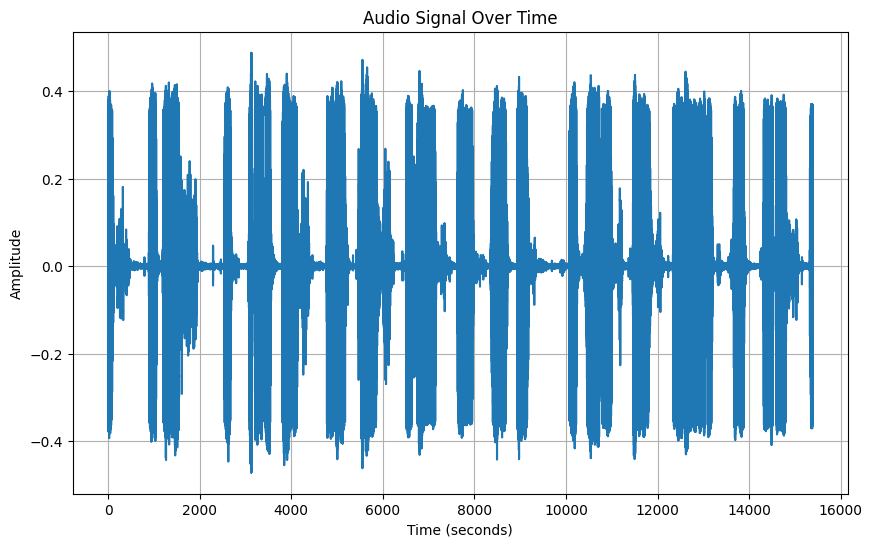

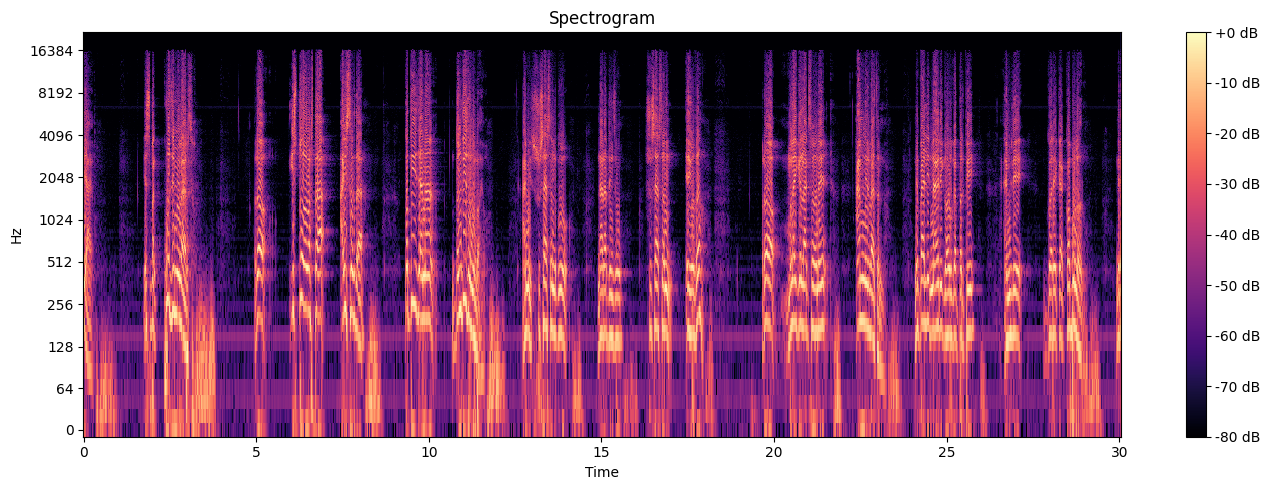

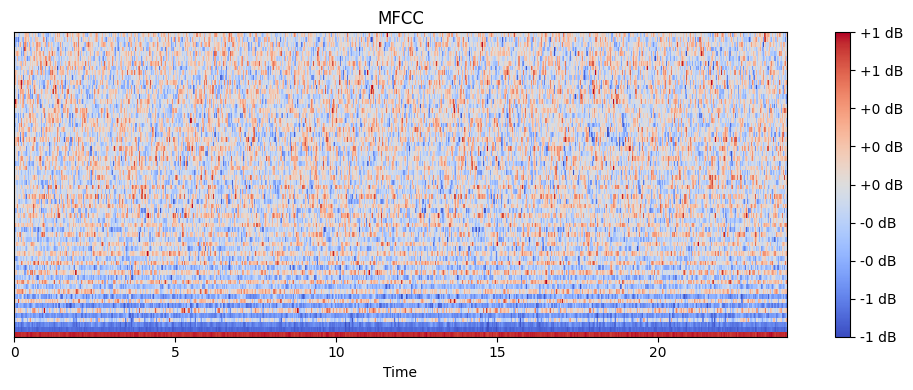

In [29]:
def plot_mfcc_vs_spectogram_and_audio(file_path):
  audio, sr = librosa.load(file_path, sr=None)

  # Create a time axis in seconds
  time = librosa.times_like(audio, sr=sr)

  # Plot the audio signal
  plt.figure(figsize=(10, 6))
  plt.plot(time, audio)
  plt.title('Audio Signal Over Time')
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.grid(True)

  # Compute the spectrogram
  D = librosa.stft(audio)
  D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

  # Display the spectrogram
  plt.figure(figsize=(14, 5))
  librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')
  plt.tight_layout()

  mfcc_base = os.path.basename(file_path)
  mfcc_base = os.path.splitext(mfcc_base)[0] + '.npy'
  mfcc_path = os.path.join('/content/processed_mfcc_files', mfcc_base)
  # Load MFCCs from .npy file
  mfccs = np.load(mfcc_path)

  # Plot MFCCs
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mfccs, x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('MFCC')
  plt.tight_layout()

  plt.show()

plot_mfcc_vs_spectogram_and_audio("/content/Nepali Speech To Text Dataset/audio_chunks/2079-11-21_46.wav")